This notebook is for testing the oversampling and to generate the weights to be used

In [1]:
from config.configs_kf import *
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import DataLoader, WeightedRandomSampler

## Test on the reduced dataset

In [2]:
train_args = agriculture_configs(net_name='Test',
                                 data='Agriculture',
                                 bands_list=['NIR', 'RGB'],
                                 kf=0, k_folder=0,
                                 note='reproduce_ACW_loss2_adax'
                                 )

train_args.input_size = [512, 512]
train_args.scale_rate = 1.  # 256./512.  # 448.0/512.0 #1.0/1.0
train_args.val_size = [512, 512]
train_args.node_size = (32, 32)
train_args.train_batch = 10
train_args.val_batch = 10

train_args.lr = 1.5e-4 / np.sqrt(3)
train_args.weight_decay = 2e-5

train_args.lr_decay = 0.9
train_args.max_iter = 1e8

train_args.snapshot = ''

train_args.print_freq = 1
train_args.save_pred = False
train_args.extra_augment = True
train_args.classes_augment = [6]
# output training configuration to a text file
train_args.ckpt_path=os.path.abspath(os.curdir)
train_dst, val_dst = train_args.get_dataset()

train set ------- 500
val set --------- 250


In [3]:
# Dataset Statistics
px_counts = np.zeros(6)
im_counts = np.zeros(6)

for img, mask in train_dst:
    mask_arr = mask.numpy()
    for i in range(1, len(px_counts) + 1):
        px_counts[i - 1] += np.sum(mask_arr == i)
        if i in mask_arr:
            im_counts[i - 1] += 1    

In [4]:
print(px_counts)
px_prop = px_counts / sum(px_counts)
print(px_prop)

[1.07786263e+08 2.61838680e+07 7.46255100e+06 5.61829730e+07
 4.01566930e+07 5.66276707e+08]
[0.13405434 0.03256501 0.00928121 0.06987506 0.04994309 0.70428129]


In [8]:
print(im_counts)
im_prop = im_counts / len(train_dst)
print(im_prop)

[ 34.  61.   8.  27.  54. 305.]
[0.068 0.122 0.016 0.054 0.108 0.61 ]


In [9]:
# Generate class weights
classes_weights = (1/6) / im_prop
print(classes_weights)

[ 2.45098039  1.36612022 10.41666667  3.08641975  1.54320988  0.27322404]


In [11]:
# Generate sample weights
sample_weights = np.zeros(len(train_dst))
index = 0
for img, mask in train_dst:
    mask_array = mask.numpy()
    sample_weights[index] = 0
    for class_label in range(len(classes_weights)):
        sample_weights[index] += np.sum(mask_array == (class_label + 1))*classes_weights[class_label]
    index += 1

In [12]:
# Normalise sample weights
sample_weights = sample_weights / np.sum(sample_weights)

In [13]:
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [14]:
train_loader = DataLoader(dataset=train_dst, batch_size=train_args.train_batch, num_workers=1, sampler=sampler)
val_loader = DataLoader(dataset=val_dst, batch_size=train_args.val_batch, num_workers=1)

In [15]:
# Verify oversampling
px_mass = np.zeros((50, 7))
im_mass = np.zeros((50, 7))
index = 0
for im, mask in train_loader:
    px_counts = np.zeros(7)
    im_counts = np.zeros(7)
    mask_arr = mask.numpy()
    for i in range(len(px_counts)):
        px_counts[i] = np.sum(mask_arr == i)
    for i in range(10):
        classes = np.unique(mask_arr)
        for cls in classes:
            if cls != 255:
                im_counts[cls] += 1
    px_mass[index, :] = px_counts / np.sum(px_counts)
    im_mass[index, :] = im_counts / np.sum(im_counts) 
    index += 1

In [16]:
print(px_mass.mean(axis = 0))

[0.42810918 0.23405675 0.00616118 0.03242297 0.15708847 0.01413643
 0.12802502]


In [17]:
print(im_mass.mean(axis = 0))

[0.18666667 0.18666667 0.08266667 0.09166667 0.17766667 0.09866667
 0.176     ]


In [18]:
x = next(iter(train_loader))
images = x[0].numpy()
labels = x[1].numpy()
print(images.shape)
print(labels.shape)

(10, 4, 512, 512)
(10, 512, 512)


In [19]:
np.unique(labels)

array([  0,   1,   4,   5,   6, 255])

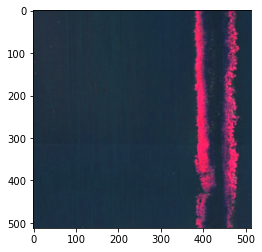

In [20]:
sample_image = images[6, 0:3, :, :].transpose(1,2,0)
plt.imshow(sample_image)

## Compute weights for Full dataset

In [24]:
# Computed on Dataset/data_notebook.ipynb - Sparsity Analysis
img_mass = np.array([0.14, 0.07, 0.02, 0.06, 0.14, 0.70])
px_counts = [110102182, 24694946, 7317282, 55115831, 41950625, 505948881]

In [25]:
weights1 = (1/6) / img_mass
print(weights1)

[1.19047619 2.38095238 8.33333333 2.77777778 1.19047619 0.23809524]


In [27]:
px_mass = px_counts / np.sum(px_counts)
print(px_mass)

[0.14776243 0.03314181 0.00982014 0.0739681  0.05629976 0.67900776]


In [30]:
weights2 = (1/6) / px_mass
print(weights2)

[ 1.12793669  5.02889503 16.97191541  2.2532236   2.96034424  0.2454562 ]


In [32]:
weights3 = np.max(px_counts) / px_counts
print(weights3)

[ 4.59526661 20.48795251 69.14437369  9.17973787 12.06058029  1.        ]
